In [1]:
import pandas as pd
import tensorflow as tf
import tensorflow.keras.layers as layers
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE

In [2]:
#The dataset contains no header for columns, hence the header parameter
data1_abnor=pd.read_csv('./ptbdb_abnormal.csv',header=None)
data1_nor=pd.read_csv('./ptbdb_normal.csv',header=None)
data2_train=pd.read_csv('./mitbih_train.csv',header=None)
data2_test=pd.read_csv('./mitbih_test.csv',header=None)

In [3]:
data1 = pd.concat([data1_abnor, data1_nor]).sample(frac=1).reset_index(drop=True)
data2 = pd.concat([data2_train, data2_test]).sample(frac=1).reset_index(drop=True)

In [4]:
data2.loc[(data2[187] != 0),187]=1

In [5]:
data = pd.concat([data1,data2]).sample(frac=1).reset_index(drop=True)

In [6]:
Y=data[data.columns[-1:]]
X=data[data.columns[:-2]]

In [7]:
random_seeed=42
x_train,x_test,y_train,y_test=train_test_split(X,Y,train_size=0.25,random_state=random_seeed)
print(x_train.shape)

(30999, 186)


In [8]:
print(len(Y[Y[187] == 0 ]))
print(len(Y[Y[187] == 1 ]))

94635
29363


In [9]:
y_train=y_train.to_numpy()
x_train=x_train.to_numpy()
#Add data dimension, doesn't actually change the data but that's how the input is expected, like it could have multiple values per timestamp
x_train=x_train.reshape([-1,186,1])

In [10]:
y_test=y_test.to_numpy()
x_test=x_test.to_numpy()
#Add data dimension, doesn't actually change the data but that's how the input is expected, like it could have multiple values per timestamp
x_test=x_test.reshape([-1,186,1])

In [11]:
model=tf.keras.Sequential([
    layers.Conv1D(64, 7, activation='relu', input_shape=(186, 1),padding='same'),
    layers.Conv1D(32, 5, activation='relu',padding='same'),
    layers.BatchNormalization(),
    layers.Conv1D(32, 5, activation='relu'),
    layers.MaxPool1D(5),
    layers.Conv1D(16, 5, activation='relu'),
    layers.BatchNormalization(),
    layers.MaxPool1D(3),
    layers.GlobalMaxPool1D(),
    layers.Flatten(),
    layers.Dense(16,activation='relu'),
    layers.Dropout(0.25),
    layers.Dense(4,activation='relu'),
    layers.Dropout(0.25),
    layers.Dense(1,activation='sigmoid') #softmax cuz categories
])

In [12]:
model.compile('adam',loss=tf.keras.losses.BinaryCrossentropy(),metrics=['accuracy']) #this was with validation
history=model.fit(x_train,y_train,batch_size=256,epochs=50,verbose=True,validation_split=0.2)

Epoch 1/50
97/97 [==============================] - 33s 262ms/step - loss: 0.5183 - accuracy: 0.7505 - val_loss: 0.6751 - val_accuracy: 0.7694
Epoch 2/50
97/97 [==============================] - 24s 245ms/step - loss: 0.4485 - accuracy: 0.7650 - val_loss: 0.6766 - val_accuracy: 0.7694
Epoch 3/50
97/97 [==============================] - 24s 251ms/step - loss: 0.4052 - accuracy: 0.7657 - val_loss: 0.6458 - val_accuracy: 0.7694
Epoch 4/50
97/97 [==============================] - 15s 155ms/step - loss: 0.3639 - accuracy: 0.8345 - val_loss: 0.6601 - val_accuracy: 0.5808
Epoch 5/50
97/97 [==============================] - 16s 162ms/step - loss: 0.3336 - accuracy: 0.8850 - val_loss: 0.5684 - val_accuracy: 0.6871
Epoch 6/50
97/97 [==============================] - 16s 163ms/step - loss: 0.3091 - accuracy: 0.8955 - val_loss: 0.3855 - val_accuracy: 0.8406
Epoch 7/50
97/97 [==============================] - 12s 121ms/step - loss: 0.2939 - accuracy: 0.9014 - val_loss: 0.2674 - val_accuracy: 0.9123

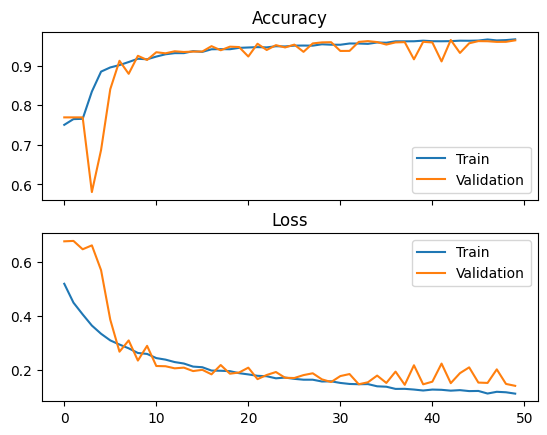

In [13]:
fig, ax = plt.subplots(2,sharex=True)
ax[0].set_title("Accuracy")
ax[0].plot(history.epoch, history.history['accuracy'],label='Train');
ax[0].plot(history.epoch, history.history['val_accuracy'],label='Validation');
ax[0].legend()
ax[1].set_title("Loss")
ax[1].plot(history.epoch, history.history['loss'],label='Train');
ax[1].plot(history.epoch, history.history['val_loss'],label='Validation');
ax[1].legend()

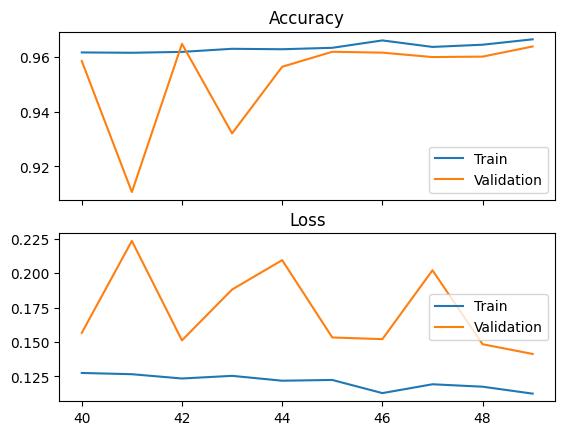

In [15]:
fig, ax = plt.subplots(2,sharex=True)
ax[0].set_title("Accuracy")
ax[0].plot(history.epoch[40:], history.history['accuracy'][40:],label='Train');
ax[0].plot(history.epoch[40:], history.history['val_accuracy'][40:],label='Validation');
ax[0].legend()
ax[1].set_title("Loss")
ax[1].plot(history.epoch[40:], history.history['loss'][40:],label='Train');
ax[1].plot(history.epoch[40:], history.history['val_loss'][40:],label='Validation');
ax[1].legend()

In [14]:
model.evaluate(x_test, y_test, verbose=True)

2907/2907 [==============================] - 14s 5ms/step - loss: 0.1633 - accuracy: 0.9601


[0.1632671058177948, 0.9600963592529297]

In [16]:
from sklearn.metrics import classification_report
y_pred = model.predict(x_test)
yy = np.array([])
for pred in y_pred:
    if pred>=0.5:
        yy=np.append(arr=yy, values=1)
    else:
        yy=np.append(arr=yy, values=0)
print(classification_report(y_test, yy))

2907/2907 [==============================] - 13s 4ms/step
              precision    recall  f1-score   support

         0.0       0.98      0.97      0.97     70877
         1.0       0.91      0.92      0.92     22122

    accuracy                           0.96     92999
   macro avg       0.94      0.95      0.95     92999
weighted avg       0.96      0.96      0.96     92999

